In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

# transform = transforms.Normalize((0.1307,), (0.3081,))
transform = None

train_set = PreloadedDataset.from_dataset(train_set, transform, device)
val_set = PreloadedDataset.from_dataset(val_set, transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, transform, device)

In [4]:
def train(
        model,
        train_set,
        val_set,
        optimiser,
        criterion,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

            x_hat = model(x)
            loss = criterion(x_hat, x)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        for x, _ in val_loader:
            x_hat = model(x)
            loss = criterion(x_hat, x)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
    return train_losses, val_losses

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.ReLU(True),

            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.ReLU(True),

            nn.Conv2d(32, 64, 4, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128, 128)
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 1, 1)),

            nn.ConvTranspose2d(128, 64, 4, 2, 0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, 2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 6, 2, padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, steps=20):
        z = self.encoder(x)
        x = self.decoder(z)
        return x
    
    def encode(self, x, steps=200):
        z = self.encoder(x)
        if steps > 0:
            z = z.detach().requires_grad_(True)
            optimiser = torch.optim.AdamW([z], lr=0.1)
            for _ in range(steps):
                x_hat = self.decoder(z)
                loss = F.mse_loss(x_hat, x)
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
        return z.detach()


model = AutoEncoder().to(device)
x = torch.randn(10, 1, 28, 28).to(device) 
model(x).shape

torch.Size([10, 1, 28, 28])

In [6]:
LR = 1e-4
WD = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

# criterion = F.binary_cross_entropy_with_logits
criterion = F.mse_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

train_losses, val_losses = train(model, train_set, val_set, optimizer, criterion, EPOCHS, BATCH_SIZE)

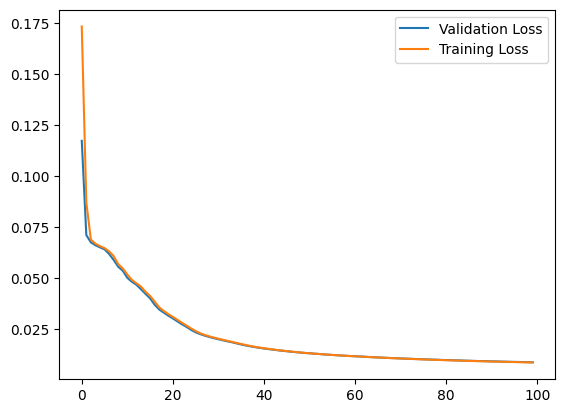

In [7]:
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend()

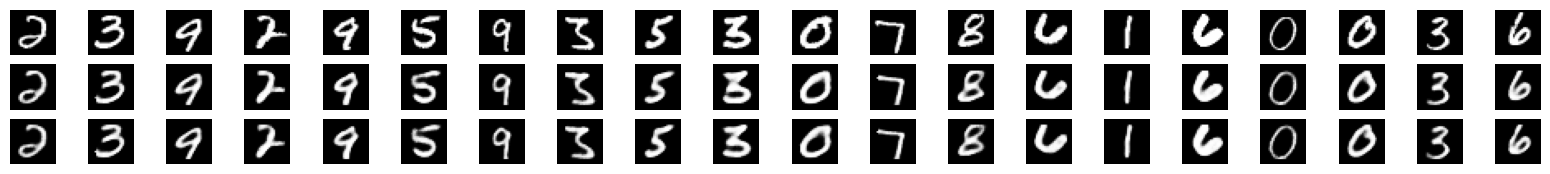

normal mse 0.13723087310791016
optimised mse 0.13539661467075348


C:\Users\joeag\AppData\Local\Temp\ipykernel_20540\114829765.py:24: UserWarning: Using a target size (torch.Size([20, 1, 28, 28])) that is different to the input size (torch.Size([20, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('normal mse', F.mse_loss(torch.cat(xs), torch.cat(x_hats)).item())
C:\Users\joeag\AppData\Local\Temp\ipykernel_20540\114829765.py:25: UserWarning: Using a target size (torch.Size([20, 1, 28, 28])) that is different to the input size (torch.Size([20, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(f'optimised mse', F.mse_loss(torch.cat(xs), torch.cat(x_hats2)).item())


In [10]:
sample_size = 20
idxs = torch.randint(0, len(test_set), (sample_size,))

xs = []
x_hats = []
x_hats2 = []
fig, axes = plt.subplots(3, sample_size, figsize=(sample_size, 2))
for i, idx in enumerate(idxs):
    x, _ = test_set[idx]
    x_hat = model(x.unsqueeze(0))
    x_hat2 = model.decoder(model.encode(x.unsqueeze(0), steps=200))
    axes[0, i].imshow(x.squeeze().cpu(), cmap='gray')
    axes[1, i].imshow(x_hat.squeeze().cpu().detach(), cmap='gray')
    axes[2, i].imshow(x_hat2.squeeze().cpu().detach(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')

    xs.append(x)
    x_hats.append(x_hat)
    x_hats2.append(x_hat2)
plt.show()

print('normal mse', F.mse_loss(torch.cat(xs), torch.cat(x_hats)).item())
print(f'optimised mse', F.mse_loss(torch.cat(xs), torch.cat(x_hats2)).item())

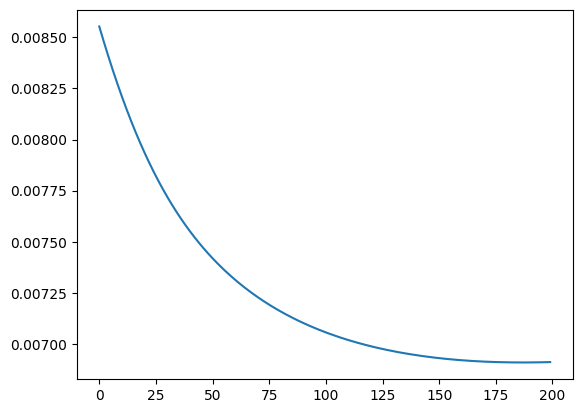

In [8]:
x = test_set[:][0]
z = model.encoder(x)
z = z.detach().requires_grad_(True)
optimiser = torch.optim.AdamW([z], lr=0.1)
mses = []
for _ in range(200):
    x_hat = model.decoder(z)
    mse = F.mse_loss(x_hat, x)
    mses.append(mse.item())
    optimiser.zero_grad()
    mse.backward()
    optimiser.step()
plt.plot(mses)

In [14]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(128, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            # x = model.encoder(x)
            x = model.encode(x)
            pred = classifier(x.detach())
            loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            # x = model.encoder(x)
            x = model.encode(x)
            pred = classifier(x.detach())
            loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [15]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, BATCH_SIZE)

KeyboardInterrupt: 

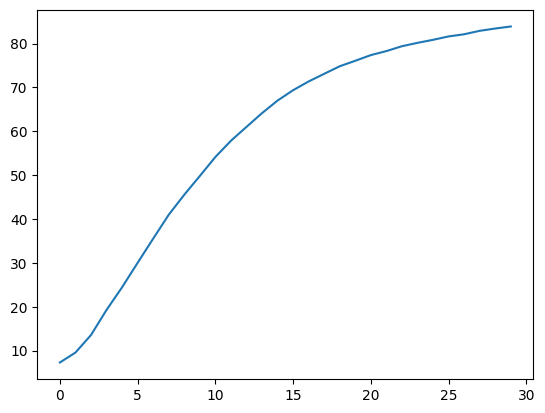

In [16]:
plt.plot(c_v_accs, label='Validation Accuracy')